# Agentic RAG: Factory Safety Assistant

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/agentic_rag_factory_safety_assistant_with_langgraph_langchain_mongodb.ipynb)

In [ ]:
%pip install --quiet datasets pandas pymongo langchain_openai

In [2]:
import getpass
import os


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

In [3]:
# Non-sensitive environment variables
OPEN_AI_EMBEDDING_MODEL = "text-embedding-3-small"
OPEN_AI_EMBEDDING_MODEL_DIMENSION = 256

# Uncomment below to utilize langSmith
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_PROJECT"] = "factory_safety_assistant"

# Sensitive Environment Variables
set_env_securely("OPENAI_API_KEY", "Enter your OpenAI API key: ")
# Uncomment below to utilize langSmith
# set_env_securely("LANGCHAIN_API_KEY", "Enter your LangChain API key: ")

Enter your OpenAI API key: ··········


In [5]:
# Step 1: Data Loading
import pandas as pd

# Load the accidents dataset
accidents_df = pd.read_json("accidents_incidents.json")

# Load the safety procedures datasets
safety_df = pd.read_json("safety_procedures.json")

In [15]:
# Step 1: Data Loading
import pandas as pd
from datasets import load_dataset

# Make sure you have an Hugging Face token(HF_TOKEN) in your development environemnt before running the code below
# How to get a token: https://huggingface.co/docs/hub/en/security-tokens

safety_procedure_ds = load_dataset("MongoDB/safety_procedure_dataset", split="train")
safety_df = pd.DataFrame(safety_procedure_ds)

accident_reports_ds = load_dataset("MongoDB/accident_reports", split="train")
accidents_df = pd.DataFrame(accident_reports_ds)

Repo card metadata block was not found. Setting CardData to empty.


In [16]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   incidentId         100 non-null    object        
 1   dateTime           100 non-null    datetime64[ns]
 2   location           100 non-null    object        
 3   type               100 non-null    object        
 4   description        100 non-null    object        
 5   severityLevel      100 non-null    object        
 6   relatedProcedures  100 non-null    object        
 7   immediateActions   100 non-null    object        
 8   rootCauses         100 non-null    object        
dtypes: datetime64[ns](1), object(8)
memory usage: 7.2+ KB


In [13]:
accidents_df.head()

,incidentId,dateTime,location,type,description,severityLevel,relatedProcedures,immediateActions,rootCauses
0,INC-2024-001,2024-03-08 09:01:41.295149,"{'region': 'East', 'site': 'Factory B'}",Equipment Failure,Equipment Failure occurred at Factory B.,low,[CHEM-012],Contained spill and alerted hazardous material...,"[{'category': 'procedural error', 'description..."
1,INC-2024-002,2024-02-05 09:01:41.295225,"{'region': 'East', 'site': 'Warehouse C'}",Fire Hazard,Fire Hazard occurred at Warehouse C.,high,"[CHEM-021, CONF-001]",Shut down equipment and isolated area,"[{'category': 'procedural error', 'description..."
2,INC-2024-003,2024-04-26 09:01:41.295263,"{'region': 'West', 'site': 'Plant D'}",Confined Space Incident,Confined Space Incident occurred at Plant D.,low,"[CONF-031, CONF-028, CHEM-021]",Ventilated space and removed worker,"[{'category': 'environmental factors', 'descri..."
3,INC-2024-004,2024-04-29 09:01:41.295283,"{'region': 'North', 'site': 'Warehouse C'}",Equipment Failure,Equipment Failure occurred at Warehouse C.,high,"[CONF-046, CONF-049]",Contained spill and alerted hazardous material...,"[{'category': 'procedural error', 'description..."
4,INC-2024-005,2024-05-16 09:01:41.295300,"{'region': 'West', 'site': 'Warehouse C'}",Fire Hazard,Fire Hazard occurred at Warehouse C.,high,"[CONF-043, HEIGHTS-020, CONF-007]",Contained spill and alerted hazardous material...,"[{'category': 'equipment failure', 'descriptio..."


In [17]:
safety_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   procedureId  50 non-null     object
 1   title        50 non-null     object
 2   description  50 non-null     object
 3   category     50 non-null     object
 4   steps        50 non-null     object
 5   lastUpdated  50 non-null     object
dtypes: object(6)
memory usage: 2.5+ KB


In [18]:
safety_df.head()

,procedureId,title,description,category,steps,lastUpdated
0,CONF-001,Confined Space Communication Protocol,Guidelines for confined space communication pr...,confined space,"[{'description': 'Use appropriate PPE', 'stepN...",2024-01-13T08:53:38.621899
1,HEIGHTS-002,Scaffold Safety Procedure,Guidelines for scaffold safety procedure,working at heights,[{'description': 'Ensure fall protection gear ...,2023-12-26T08:53:38.621930
2,CHEM-003,Chemical Spill Response Procedure,Guidelines for chemical spill response procedure,chemical handling,"[{'description': 'Use proper ventilation', 'st...",2024-04-27T08:53:38.621945
3,CONF-004,Advanced Confined Space Safety,Guidelines for advanced confined space safety,confined space,[{'description': 'Assess the confined space fo...,2024-03-31T08:53:38.621957
4,HEIGHTS-005,Fall Protection Procedure,Guidelines for fall protection procedure,working at heights,[{'description': 'Ensure fall protection gear ...,2024-07-29T08:53:38.621969


In [19]:
import numpy as np


def combine_attributes(df, attributes):
    """
    Combine specified attributes of a DataFrame into a single column,
    converting all attributes to strings and handling various data types.

    Parameters:
    df (pandas.DataFrame): The input DataFrame
    attributes (list): List of column names to combine

    Returns:
    pandas.DataFrame: The input DataFrame with an additional 'combined_info' column
    """

    def combine_row(row):
        combined = []
        for attr in attributes:
            if attr in row.index:
                value = row[attr]
                if isinstance(value, (pd.Series, np.ndarray, list)):
                    # Handle array-like objects
                    if len(value) > 0 and not pd.isna(value).all():
                        combined.append(f"{attr.capitalize()}: {value!s}")
                elif not pd.isna(value):
                    combined.append(f"{attr.capitalize()}: {value!s}")
        return " ".join(combined)

    df["combined_info"] = df.apply(combine_row, axis=1)
    return df

In [20]:
accident_attributes_to_combine = [
    "type",
    "description",
    "immediateActions",
    "rootCauses",
]
accidents_df = combine_attributes(accidents_df, accident_attributes_to_combine)

In [21]:
safety_procedures_attributes_to_combine = ["title", "description", "category", "steps"]
safety_df = combine_attributes(safety_df, safety_procedures_attributes_to_combine)

In [22]:
first_datapoint_accident = accidents_df.iloc[0]
print(first_datapoint_accident["combined_info"])

Type: Equipment Failure Description: Equipment Failure occurred at Factory B. Immediateactions: Contained spill and alerted hazardous material team Rootcauses: [{'category': 'procedural error', 'description': 'Inadequate safety checks', 'preventionRecommendations': 'Review and update safety procedures'}]


In [23]:
first_datapoint_safety = safety_df.iloc[0]
print(first_datapoint_safety["combined_info"])

Title: Confined Space Communication Protocol Description: Guidelines for confined space communication protocol Category: confined space Steps: [{'description': 'Use appropriate PPE', 'stepNumber': 1}, {'description': 'Assess the confined space for hazards', 'stepNumber': 2}, {'description': 'Obtain necessary permits', 'stepNumber': 3}, {'description': 'Monitor the atmosphere', 'stepNumber': 4}]


In [24]:
import tiktoken
from langchain_openai import OpenAIEmbeddings
from tqdm import tqdm

MAX_TOKENS = 8191  # Maximum tokens for text-embedding-3-small
OVERLAP = 50

# Load the embedding model
embedding_model = OpenAIEmbeddings(
    model=OPEN_AI_EMBEDDING_MODEL, dimensions=OPEN_AI_EMBEDDING_MODEL_DIMENSION
)


def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def chunk_text(text, max_tokens=MAX_TOKENS, overlap=OVERLAP):
    """
    Split the text into overlapping chunks based on token count.
    """
    encoding = tiktoken.get_encoding("cl100k_base")
    tokens = encoding.encode(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens - overlap):
        chunk_tokens = tokens[i : i + max_tokens]
        chunk = encoding.decode(chunk_tokens)
        chunks.append(chunk)
    return chunks


def get_embedding(input_data, model=OPEN_AI_EMBEDDING_MODEL):
    """
    Generate embeddings for the 'combined_attributes' column and duplicate the row for each chunk
    or generate embeddings for a given string.
    """
    if isinstance(input_data, str):
        text = input_data
    else:
        text = input_data["combined_info"]

    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    # Split text into chunks if it's too long
    chunks = chunk_text(text)

    # Embed each chunk
    chunk_embeddings = []
    for chunk in chunks:
        chunk = chunk.replace("\n", " ")
        embedding = embedding_model.embed_query(text=chunk)
        chunk_embeddings.append(embedding)

    if isinstance(input_data, str):
        # Return list of embeddings for string input
        return chunk_embeddings[0]
    # Create duplicated rows for each chunk with the respective embedding for row input
    duplicated_rows = []
    for embedding in chunk_embeddings:
        new_row = input_data.copy()
        new_row["embedding"] = embedding
        duplicated_rows.append(new_row)
    return duplicated_rows

In [25]:
# Apply the function and expand the dataset
duplicated_data_accidents = []
for _, row in tqdm(
    accidents_df.iterrows(),
    desc="Generating embeddings and duplicating rows",
    total=len(accidents_df),
):
    duplicated_rows = get_embedding(row)
    duplicated_data_accidents.extend(duplicated_rows)

# Create a new DataFrame from the duplicated data
accidents_df = pd.DataFrame(duplicated_data_accidents)

Generating embeddings and duplicating rows: 100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


In [26]:
# Apply the function and expand the dataset
duplicated_data_safey = []
for _, row in tqdm(
    safety_df.iterrows(),
    desc="Generating embeddings and duplicating rows",
    total=len(safety_df),
):
    duplicated_rows = get_embedding(row)
    duplicated_data_safey.extend(duplicated_rows)

# Create a new DataFrame from the duplicated data
safety_df = pd.DataFrame(duplicated_data_safey)

Generating embeddings and duplicating rows: 100%|██████████| 50/50 [00:09<00:00,  5.48it/s]


In [27]:
accidents_df.head()

,incidentId,dateTime,location,type,description,severityLevel,relatedProcedures,immediateActions,rootCauses,combined_info,embedding
0,INC-2024-001,2024-03-08 09:01:41.295149,"{'region': 'East', 'site': 'Factory B'}",Equipment Failure,Equipment Failure occurred at Factory B.,low,[CHEM-012],Contained spill and alerted hazardous material...,"[{'category': 'procedural error', 'description...",Type: Equipment Failure Description: Equipment...,"[-0.04604925215244293, 0.12573133409023285, 0...."
1,INC-2024-002,2024-02-05 09:01:41.295225,"{'region': 'East', 'site': 'Warehouse C'}",Fire Hazard,Fire Hazard occurred at Warehouse C.,high,"[CHEM-021, CONF-001]",Shut down equipment and isolated area,"[{'category': 'procedural error', 'description...",Type: Fire Hazard Description: Fire Hazard occ...,"[-0.04193640872836113, 0.05664677545428276, 0...."
2,INC-2024-003,2024-04-26 09:01:41.295263,"{'region': 'West', 'site': 'Plant D'}",Confined Space Incident,Confined Space Incident occurred at Plant D.,low,"[CONF-031, CONF-028, CHEM-021]",Ventilated space and removed worker,"[{'category': 'environmental factors', 'descri...",Type: Confined Space Incident Description: Con...,"[-0.0865219384431839, 0.0783221423625946, 0.11..."
3,INC-2024-004,2024-04-29 09:01:41.295283,"{'region': 'North', 'site': 'Warehouse C'}",Equipment Failure,Equipment Failure occurred at Warehouse C.,high,"[CONF-046, CONF-049]",Contained spill and alerted hazardous material...,"[{'category': 'procedural error', 'description...",Type: Equipment Failure Description: Equipment...,"[-0.022067412734031677, 0.09491231292486191, 0..."
4,INC-2024-005,2024-05-16 09:01:41.295300,"{'region': 'West', 'site': 'Warehouse C'}",Fire Hazard,Fire Hazard occurred at Warehouse C.,high,"[CONF-043, HEIGHTS-020, CONF-007]",Contained spill and alerted hazardous material...,"[{'category': 'equipment failure', 'descriptio...",Type: Fire Hazard Description: Fire Hazard occ...,"[-0.021989304572343826, 0.046285584568977356, ..."


In [28]:
safety_df.head()

,procedureId,title,description,category,steps,lastUpdated,combined_info,embedding
0,CONF-001,Confined Space Communication Protocol,Guidelines for confined space communication pr...,confined space,"[{'description': 'Use appropriate PPE', 'stepN...",2024-01-13T08:53:38.621899,Title: Confined Space Communication Protocol D...,"[0.009534717537462711, 0.06708501279354095, 0...."
1,HEIGHTS-002,Scaffold Safety Procedure,Guidelines for scaffold safety procedure,working at heights,[{'description': 'Ensure fall protection gear ...,2023-12-26T08:53:38.621930,Title: Scaffold Safety Procedure Description: ...,"[-0.0013834232231602073, 0.08337806910276413, ..."
2,CHEM-003,Chemical Spill Response Procedure,Guidelines for chemical spill response procedure,chemical handling,"[{'description': 'Use proper ventilation', 'st...",2024-04-27T08:53:38.621945,Title: Chemical Spill Response Procedure Descr...,"[-0.06862455606460571, 0.07193397730588913, 0...."
3,CONF-004,Advanced Confined Space Safety,Guidelines for advanced confined space safety,confined space,[{'description': 'Assess the confined space fo...,2024-03-31T08:53:38.621957,Title: Advanced Confined Space Safety Descript...,"[-0.01785854995250702, 0.08748620748519897, 0...."
4,HEIGHTS-005,Fall Protection Procedure,Guidelines for fall protection procedure,working at heights,[{'description': 'Ensure fall protection gear ...,2024-07-29T08:53:38.621969,Title: Fall Protection Procedure Description: ...,"[-0.09375722706317902, 0.09517853707075119, 0...."


In [29]:
set_env_securely("MONGO_URI", "Enter your MongoDB URI: ")

Enter your MongoDB URI: ··········


In [30]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri, appname="devrel.showcase.factory_safety_assistant.python"
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    print("Connection to MongoDB failed")
    return None


MONGO_URI = os.environ["MONGO_URI"]

if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "factory_safety_use_case"
SAFETY_PROCEDURES_COLLECTION = "safety_procedures"
ACCIDENTS_REPORT_COLLECTION = "accident_report"

db = mongo_client.get_database(DB_NAME)
safety_procedure_collection = db.get_collection(SAFETY_PROCEDURES_COLLECTION)
accident_report_collection = db.get_collection(ACCIDENTS_REPORT_COLLECTION)

Connection to MongoDB successful


In [31]:
# Programmatically create vector search index for both colelctions
from pymongo.operations import SearchIndexModel


def setup_vector_search_index_with_filter(
    collection, index_definition, index_name="vector_index_with_filter"
):
    """
    Setup a vector search index for a MongoDB collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index_with_filter")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition,
        name=index_name,
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")
        # time.sleep(20)  # Sleep for 20 seconds
        print(f"New index '{index_name}' created successfully:", result)
    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")

In [32]:
# Define the vector search index definition
vector_search_index_definition_safety_procedure = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "embedding": {
                "dimensions": 256,
                "similarity": "cosine",
                "type": "knnVector",
            },
            "procedureId": {"type": "string"},
        },
    }
}

vector_search_index_definition_accident_reports = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "embedding": {
                "dimensions": 256,
                "similarity": "cosine",
                "type": "knnVector",
            },
            "incidentId": {"type": "string"},
        },
    }
}

In [33]:
setup_vector_search_index_with_filter(
    safety_procedure_collection, vector_search_index_definition_safety_procedure
)
setup_vector_search_index_with_filter(
    accident_report_collection, vector_search_index_definition_accident_reports
)

Error creating new vector search index 'vector_index_with_filter': Duplicate Index, full error: {'ok': 0.0, 'errmsg': 'Duplicate Index', 'code': 68, 'codeName': 'IndexAlreadyExists', '$clusterTime': {'clusterTime': Timestamp(1724932771, 48), 'signature': {'hash': b'\xf1\xee\x04\xa0w:\xb7{)\xf6\xbc\xc2\x103i\xebcv\xaet', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1724932771, 48)}
Error creating new vector search index 'vector_index_with_filter': Duplicate Index, full error: {'ok': 0.0, 'errmsg': 'Duplicate Index', 'code': 68, 'codeName': 'IndexAlreadyExists', '$clusterTime': {'clusterTime': Timestamp(1724932771, 48), 'signature': {'hash': b'\xf1\xee\x04\xa0w:\xb7{)\xf6\xbc\xc2\x103i\xebcv\xaet', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1724932771, 48)}


In [34]:
# Delete any existing records in the collections
safety_procedure_collection.delete_many({})
accident_report_collection.delete_many({})

DeleteResult({'n': 100, 'electionId': ObjectId('7fffffff0000000000000032'), 'opTime': {'ts': Timestamp(1724932786, 150), 't': 50}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1724932786, 150), 'signature': {'hash': b'\xa1^\xb7L\xba\xe1vp\xedVF~\xb5\xbb\xde\xb6\xa2\xe3\xe6-', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1724932786, 150)}, acknowledged=True)

In [35]:
import pandas as pd
from pymongo.errors import BulkWriteError


def insert_df_to_mongodb(df, collection, batch_size=1000):
    """
    Insert a pandas DataFrame into a MongoDB collection.

    Parameters:
    df (pandas.DataFrame): The DataFrame to insert
    collection (pymongo.collection.Collection): The MongoDB collection to insert into
    batch_size (int): Number of documents to insert in each batch

    Returns:
    int: Number of documents successfully inserted
    """
    total_inserted = 0

    # Convert DataFrame to list of dictionaries
    records = df.to_dict("records")

    # Insert in batches
    for i in range(0, len(records), batch_size):
        batch = records[i : i + batch_size]
        try:
            result = collection.insert_many(batch, ordered=False)
            total_inserted += len(result.inserted_ids)
            print(
                f"Inserted batch {i//batch_size + 1}: {len(result.inserted_ids)} documents"
            )
        except BulkWriteError as bwe:
            total_inserted += bwe.details["nInserted"]
            print(
                f"Batch {i//batch_size + 1} partially inserted. {bwe.details['nInserted']} inserted, {len(bwe.details['writeErrors'])} failed."
            )

    return total_inserted

In [36]:
def print_dataframe_info(df, df_name):
    print(f"\n{df_name} DataFrame info:")
    print(df.info())
    print(f"\nFirst few rows of the {df_name} DataFrame:")
    print(df.head())

In [37]:
# Insert safety procedures
try:
    total_inserted_safety = insert_df_to_mongodb(safety_df, safety_procedure_collection)
    print(
        f"Safety procedures data ingestion completed. Total documents inserted: {total_inserted_safety}"
    )
except Exception as e:
    print(f"An error occurred while inserting safety procedures: {e}")
    print("Pandas version:", pd.__version__)
    print_dataframe_info(safety_df, "Safety Procedures")

# Insert accident reports
try:
    total_inserted_accidents = insert_df_to_mongodb(
        accidents_df, accident_report_collection
    )
    print(
        f"Accident reports data ingestion completed. Total documents inserted: {total_inserted_accidents}"
    )
except Exception as e:
    print(f"An error occurred while inserting accident reports: {e}")
    print("Pandas version:", pd.__version__)
    print_dataframe_info(accidents_df, "Accident Reports")

# Final summary
print("\nInsertion Summary:")
print(
    f"Safety Procedures inserted: {total_inserted_safety if 'total_inserted_safety' in locals() else 'Failed'}"
)
print(
    f"Accident Reports inserted: {total_inserted_accidents if 'total_inserted_accidents' in locals() else 'Failed'}"
)

Inserted batch 1: 50 documents
Safety procedures data ingestion completed. Total documents inserted: 50
Inserted batch 1: 100 documents
Accident reports data ingestion completed. Total documents inserted: 100

Insertion Summary:
Safety Procedures inserted: 50
Accident Reports inserted: 100


In [38]:
def vector_search(user_query, collection):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search pipeline
    vector_search_stage = {
        "$vectorSearch": {
            "index": "vector_index_with_filter",
            "queryVector": query_embedding,
            "path": "embedding",
            "numCandidates": 150,  # Number of candidate matches to consider
            "limit": 5,  # Return top 4 matches
        }
    }

    unset_stage = {
        "$unset": "embedding"  # Exclude the 'embedding' field from the results
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field,
            "combined_info": 1,
            "score": {
                "$meta": "vectorSearchScore"  # Include the search score
            },
        }
    }

    pipeline = [vector_search_stage, unset_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

In [39]:
def get_vector_search_result(query, collection):
    get_knowledge = vector_search(query, collection)
    search_results = []
    for result in get_knowledge:
        search_results.append(
            [result.get("score", "N/A"), result.get("combined_info", "N/A")]
        )
    return search_results

In [40]:
import tabulate

query = "Get me a saftey procedure related to helmet incidents"
source_information = get_vector_search_result(query, safety_procedure_collection)

table_headers = ["Similarity Score", "Combined Information"]
table = tabulate.tabulate(source_information, headers=table_headers, tablefmt="grid")

combined_information = f"""Query: {query}

Continue to answer the query by using the Search Results:

{table}
"""

print(combined_information)

Query: Get me a saftey procedure related to helmet incidents

Continue to answer the query by using the Search Results:

+--------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   Similarity Score | Combined Information                                                                                                                                                                                                                                                                                                                                                       

In [36]:
%pip install --quiet -U langchain langchain_mongodb langgraph langsmith motor langchain_anthropic # langchain-groq

In [37]:
set_env_securely("ANTHROPIC_API_KEY", "Enter your Anthropic API key: ")

Enter your Anthropic API key: ··········


In [38]:
# Uncomment below to utilize Groq
set_env_securely("GROQ_API_KEY", "Enter your Groq API key: ")

Enter your Groq API key: ··········


In [64]:
# Programatically create search indexes


def create_collection_search_index(collection, index_definition, index_name):
    """
    Create a search index for a MongoDB Atlas collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary defining the index mappings
    index_name: String name for the index

    Returns:
    str: Result of the index creation operation
    """

    try:
        search_index_model = SearchIndexModel(
            definition=index_definition, name=index_name
        )

        result = collection.create_search_index(model=search_index_model)
        print(f"Search index '{index_name}' created successfully")
        return result
    except Exception as e:
        print(f"Error creating search index: {e!s}")
        return None


def print_collection_search_indexes(collection):
    """
    Print all search indexes for a given collection.

    Args:
    collection: MongoDB collection object
    """
    print(f"\nSearch indexes for collection '{collection.name}':")
    for index in collection.list_search_indexes():
        print(f"Index: {index['name']}")

In [65]:
safety_procedure_collection_text_index_definition = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "title": {"type": "string"},
            "description": {"type": "string"},
            "category": {"type": "string"},
            "steps.description": {"type": "string"},
        },
    }
}

create_collection_search_index(
    safety_procedure_collection,
    safety_procedure_collection_text_index_definition,
    "text_search_index",
)

# Print all indexes in the collection
print_collection_search_indexes(safety_procedure_collection)

Error creating search index: Duplicate Index, full error: {'ok': 0.0, 'errmsg': 'Duplicate Index', 'code': 68, 'codeName': 'IndexAlreadyExists', '$clusterTime': {'clusterTime': Timestamp(1724864038, 1), 'signature': {'hash': b'\x08\x19U\xbb\xe3Y\txs\xad?y\xd1"\x0b]\xa5\xb5*\x13', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1724864038, 1)}

Search indexes for collection 'safety_procedures':
Index: vector_index_with_filter
Index: text_search_index


In [66]:
accident_report_collection_text_index_definition = {
    "mappings": {
        "dynamic": True,
        "fields": {"type": {"type": "string"}, "description": {"type": "string"}},
    }
}

create_collection_search_index(
    accident_report_collection,
    accident_report_collection_text_index_definition,
    "text_search_index",
)

# Print all indexes in the collection
print_collection_search_indexes(accident_report_collection)

Error creating search index: Duplicate Index, full error: {'ok': 0.0, 'errmsg': 'Duplicate Index', 'code': 68, 'codeName': 'IndexAlreadyExists', '$clusterTime': {'clusterTime': Timestamp(1724864038, 1), 'signature': {'hash': b'\x08\x19U\xbb\xe3Y\txs\xad?y\xd1"\x0b]\xa5\xb5*\x13', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1724864038, 1)}

Search indexes for collection 'accident_report':
Index: vector_index_with_filter
Index: text_search_index


In [67]:
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain_mongodb.retrievers import MongoDBAtlasHybridSearchRetriever
from langchain_openai import OpenAIEmbeddings

ATLAS_VECTOR_SEARCH_INDEX = "vector_index_with_filter"
embedding_model = OpenAIEmbeddings(
    model=OPEN_AI_EMBEDDING_MODEL, dimensions=OPEN_AI_EMBEDDING_MODEL_DIMENSION
)

# Vector Stores Intialisation
vector_store_safety_procedures = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGO_URI,
    namespace=DB_NAME + "." + SAFETY_PROCEDURES_COLLECTION,
    embedding=embedding_model,
    index_name=ATLAS_VECTOR_SEARCH_INDEX,
    text_key="combined_info",
)

hybrid_search = MongoDBAtlasHybridSearchRetriever(
    vectorstore=vector_store_safety_procedures,
    search_index_name="text_search_index",
    top_k=5,
)

hybrid_search_result = hybrid_search.get_relevant_documents(query)

In [68]:
def hybrid_search_results_to_table(search_results):
    """
    Convert hybrid search results to a formatted markdown table.

    Args:
    search_results (list): List of Document objects containing search results

    Returns:
    str: Formatted markdown table of search results
    """
    # Extract relevant information from each result
    data = []
    for rank, doc in enumerate(search_results, start=1):
        metadata = doc.metadata
        data.append(
            {
                "Rank": rank,
                "Procedure ID": metadata["procedureId"],
                "Title": metadata["title"],
                "Category": metadata["category"],
                "Vector Score": round(metadata["vector_score"], 5),
                "Full-text Score": round(metadata["fulltext_score"], 5),
                "Total Score": round(metadata["score"], 5),
            }
        )

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Generate markdown table
    table = tabulate.tabulate(df, headers="keys", tablefmt="pipe", showindex=False)

    return table

In [69]:
table = hybrid_search_results_to_table(hybrid_search_result)
print(table)

|   Rank | Procedure ID   | Title                           | Category           |   Vector Score |   Full-text Score |   Total Score |
|-------:|:---------------|:--------------------------------|:-------------------|---------------:|------------------:|--------------:|
|      1 | HEIGHTS-020    | Scaffold Safety Procedure       | working at heights |        0.01587 |           0.01538 |       0.03126 |
|      2 | HEIGHTS-050    | Scaffold Safety Procedure       | working at heights |        0.01639 |           0       |       0.01639 |
|      3 | CONF-007       | Confined Space Rescue Procedure | confined space     |        0       |           0.01639 |       0.01639 |
|      4 | HEIGHTS-044    | Ladder Safety Procedure         | working at heights |        0       |           0.01613 |       0.01613 |
|      5 | HEIGHTS-002    | Scaffold Safety Procedure       | working at heights |        0.01613 |           0       |       0.01613 |


In [70]:
from langchain_mongodb.retrievers import MongoDBAtlasFullTextSearchRetriever

full_text_search = MongoDBAtlasFullTextSearchRetriever(
    collection=safety_procedure_collection,
    search_index_name="text_search_index",
    search_field="description",
    top_k=5,
)
full_text_search_result = full_text_search.get_relevant_documents("Guidelines")

In [71]:
print(full_text_search_result)

[Document(metadata={'_id': '66cf513f36201a6c2ff0dcf6', 'procedureId': 'HEIGHTS-050', 'title': 'Scaffold Safety Procedure', 'category': 'working at heights', 'steps': [{'stepNumber': 1, 'description': 'Check equipment and anchor points'}, {'stepNumber': 2, 'description': 'Identify potential hazards'}, {'stepNumber': 3, 'description': 'Ensure fall protection gear is worn'}, {'stepNumber': 4, 'description': 'Follow emergency rescue plan'}, {'stepNumber': 5, 'description': 'Maintain three points of contact'}], 'lastUpdated': '2023-10-07T08:53:38.622518', 'combined_info': "Title: Scaffold Safety Procedure Description: Guidelines for scaffold safety procedure Category: working at heights Steps: [{'stepNumber': 1, 'description': 'Check equipment and anchor points'}, {'stepNumber': 2, 'description': 'Identify potential hazards'}, {'stepNumber': 3, 'description': 'Ensure fall protection gear is worn'}, {'stepNumber': 4, 'description': 'Follow emergency rescue plan'}, {'stepNumber': 5, 'descript

## MongoDB Checkpointer


In [72]:
import pickle
from contextlib import AbstractContextManager
from datetime import datetime, timezone
from types import TracebackType
from typing import Any, AsyncIterator, Dict, List, Optional, Tuple, Union

from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    Checkpoint,
    CheckpointMetadata,
    CheckpointTuple,
    SerializerProtocol,
)
from langgraph.checkpoint.serde.jsonplus import JsonPlusSerializer
from motor.motor_asyncio import AsyncIOMotorClient
from typing_extensions import Self


class JsonPlusSerializerCompat(JsonPlusSerializer):
    def loads(self, data: bytes) -> Any:
        if data.startswith(b"\x80") and data.endswith(b"."):
            return pickle.loads(data)
        return super().loads(data)


class MongoDBSaver(AbstractContextManager, BaseCheckpointSaver):
    serde = JsonPlusSerializerCompat()

    client: AsyncIOMotorClient
    db_name: str
    collection_name: str

    def __init__(
        self,
        client: AsyncIOMotorClient,
        db_name: str,
        collection_name: str,
        *,
        serde: Optional[SerializerProtocol] = None,
    ) -> None:
        super().__init__(serde=serde)
        self.client = client
        self.db_name = db_name
        self.collection_name = collection_name
        self.collection = client[db_name][collection_name]

    def __enter__(self) -> Self:
        return self

    def __exit__(
        self,
        __exc_type: Optional[type[BaseException]],
        __exc_value: Optional[BaseException],
        __traceback: Optional[TracebackType],
    ) -> Optional[bool]:
        return True

    async def aget_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        if config["configurable"].get("thread_ts"):
            query = {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": config["configurable"]["thread_ts"],
            }
        else:
            query = {"thread_id": config["configurable"]["thread_id"]}

        doc = await self.collection.find_one(query, sort=[("thread_ts", -1)])
        if doc:
            return CheckpointTuple(
                config,
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )
        return None

    async def alist(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ) -> AsyncIterator[CheckpointTuple]:
        query = {}
        if config is not None:
            query["thread_id"] = config["configurable"]["thread_id"]
        if filter:
            for key, value in filter.items():
                query[f"metadata.{key}"] = value
        if before is not None:
            query["thread_ts"] = {"$lt": before["configurable"]["thread_ts"]}

        cursor = self.collection.find(query).sort("thread_ts", -1)
        if limit:
            cursor = cursor.limit(limit)

        async for doc in cursor:
            yield CheckpointTuple(
                {
                    "configurable": {
                        "thread_id": doc["thread_id"],
                        "thread_ts": doc["thread_ts"],
                    }
                },
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )

    async def aput(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
        new_versions: Optional[dict[str, Union[str, float, int]]],
    ) -> RunnableConfig:
        doc = {
            "thread_id": config["configurable"]["thread_id"],
            "thread_ts": checkpoint["id"],
            "checkpoint": self.serde.dumps(checkpoint),
            "metadata": self.serde.dumps(metadata),
        }
        if config["configurable"].get("thread_ts"):
            doc["parent_ts"] = config["configurable"]["thread_ts"]
        await self.collection.insert_one(doc)
        return {
            "configurable": {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": checkpoint["id"],
            }
        }

    # Implement synchronous methods as well for compatibility
    def get_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        raise NotImplementedError("Use aget_tuple for asynchronous operations")

    def list(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ):
        raise NotImplementedError("Use alist for asynchronous operations")

    def put(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
    ) -> RunnableConfig:
        raise NotImplementedError("Use aput for asynchronous operations")

    async def aput_writes(
        self,
        config: RunnableConfig,
        writes: List[Tuple[str, Any]],
        task_id: str,
    ) -> None:
        """Asynchronously store intermediate writes linked to a checkpoint."""
        docs = []
        for channel, value in writes:
            doc = {
                "thread_id": config["configurable"]["thread_id"],
                "task_id": task_id,
                "channel": channel,
                "value": self.serde.dumps(value),
                "timestamp": datetime.now(timezone.utc).isoformat(),
            }
            docs.append(doc)

        if docs:
            await self.collection.insert_many(docs)

## Tool Definitions

In [73]:
from typing import Any, Dict

from langchain.agents import tool


@tool
def safety_procedures_vector_search_tool(query: str, k: int = 5):
    """
    Perform a vector similarity search on safety procedures.

    Args:
        query (str): The search query string.
        k (int, optional): Number of top results to return. Defaults to 5.

    Returns:
        list: List of tuples (Document, score), where Document is a safety procedure
              and score is the similarity score (lower is more similar).

    Note:
        Uses the global vector_store_safety_procedures for the search.
    """

    vector_search_results = vector_store_safety_procedures.similarity_search_with_score(
        query=query, k=k
    )
    return vector_search_results


@tool
def safety_procedures_full_text_search_tool(query: str, k: int = 5):
    """
    Perform a full-text search on safety procedures.

    Args:
        query (str): The search query string.
        k (int, optional): Number of top results to return. Defaults to 5.

    Returns:
        list: Relevant safety procedure documents matching the query.
    """

    full_text_search = MongoDBAtlasFullTextSearchRetriever(
        collection=safety_procedure_collection,
        search_index_name="text_search_index",
        search_field="description",
        top_k=k,
    )

    full_text_search_result = full_text_search.get_relevant_documents(query)


@tool
def safety_procedures_hybrid_search_tool(query: str):
    """
    Perform a hybrid (vector + full-text) search on safety procedures.

    Args:
        query (str): The search query string.

    Returns:
        list: Relevant safety procedure documents from hybrid search.

    Note:
        Uses both vector_store_safety_procedures and text_search_index.
    """

    hybrid_search = MongoDBAtlasHybridSearchRetriever(
        vectorstore=vector_store_safety_procedures,
        search_index_name="text_search_index",
        top_k=5,
    )

    hybrid_search_result = hybrid_search.get_relevant_documents(query)

    return hybrid_search_result

In [74]:
from typing import List

from pydantic import BaseModel, Field


class Step(BaseModel):
    stepNumber: int = Field(..., ge=1)
    description: str


class SafetyProcedure(BaseModel):
    procedureId: str
    title: str
    description: str
    category: str
    steps: List[Step]
    lastUpdated: datetime = Field(default_factory=datetime.now)


def create_safety_procedure_document(procedure_data: dict) -> dict:
    """
    Create a new safety procedure document from a dictionary, using Pydantic for validation.

    Args:
    procedure_data (dict): Dictionary representing the new safety procedure

    Returns:
    dict: Validated and formatted safety procedure document

    Raises:
    ValidationError: If the input data doesn't match the SafetyProcedure schema
    """
    try:
        # Create a SafetyProcedure instance, which will validate the data
        safety_procedure = SafetyProcedure(**procedure_data)

        # Convert the Pydantic model to a dictionary
        document = safety_procedure.dict()

        # Ensure steps are properly numbered
        for i, step in enumerate(document["steps"], start=1):
            step["stepNumber"] = i

        return document
    except Exception as e:
        raise ValueError(f"Invalid safety procedure data: {e!s}")


# Tool to add new safety procedures
@tool
def create_new_safety_procedures(new_procedure: dict):
    """
    Create and validate a new safety procedure document.

    Args:
        new_procedure (dict): Dictionary containing the new safety procedure data.

    Returns:
        dict: Validated and formatted safety procedure document.

    Raises:
        ValueError: If the input data is invalid or doesn't match the required schema.

    Note:
        Uses Pydantic for data validation via create_safety_procedure_document function.
    """
    new_safety_procedure_document = create_safety_procedure_document(new_procedure)
    return new_safety_procedure_document

In [75]:
vector_store_accident_reports = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGO_URI,
    namespace=DB_NAME + "." + ACCIDENTS_REPORT_COLLECTION,
    embedding=embedding_model,
    index_name=ATLAS_VECTOR_SEARCH_INDEX,
    text_key="combined_info",
)


@tool
def accident_reports_vector_search_tool(query: str, k: int = 5):
    """
    Perform a vector similarity search on accident reports.

    Args:
        query (str): The search query string.
        k (int, optional): Number of top results to return. Defaults to 5.

    Returns:
        list: List of tuples (Document, score), where Document is an accident report
              and score is the similarity score (lower is more similar).

    Note:
        Uses the global vector_store_accident_reports for the search.
    """
    vector_search_results = vector_store_accident_reports.similarity_search_with_score(
        query=query, k=k
    )
    return vector_search_results


@tool
def accident_reports_full_text_search_tool(query: str, k: int = 5):
    """
    Perform a full-text search on accident reports.

    Args:
        query (str): The search query string.
        k (int, optional): Number of top results to return. Defaults to 5.

    Returns:
        list: Relevant accident report documents matching the query.
    """
    full_text_search = MongoDBAtlasFullTextSearchRetriever(
        collection=accident_report_collection,
        search_index_name="text_search_index",
        search_field="description",
        top_k=k,
    )

    return full_text_search.get_relevant_documents(query)


@tool
def accident_reports_hybrid_search_tool(query: str):
    """
    Perform a hybrid (vector + full-text) search on accident reports.

    Args:
        query (str): The search query string.

    Returns:
        list: Relevant accident report documents from hybrid search.

    Note:
        Uses both vector_store_accident_reports and accident_text_search_index.
    """
    hybrid_search = MongoDBAtlasHybridSearchRetriever(
        vectorstore=vector_store_accident_reports,
        search_index_name="text_search_index",
        top_k=5,
    )

    return hybrid_search.get_relevant_documents(query)

In [76]:
@tool
def create_new_accident_report(new_report: dict):
    """
    Create and validate a new accident report document.

    Args:
        new_report (dict): Dictionary containing the new accident report data.

    Returns:
        dict: Validated and formatted accident report document.

    Raises:
        ValueError: If the input data is invalid or doesn't match the required schema.

    Note:
        This function should implement proper validation and formatting for accident reports.
    """
    # This is a placeholder. You'll need to implement the actual creation logic
    # similar to how you've done it for safety procedures.
    return new_report  # This should be replaced with actual implementation

In [77]:
safety_procedure_collection_tools = [
    safety_procedures_vector_search_tool,
    safety_procedures_full_text_search_tool,
    safety_procedures_hybrid_search_tool,
    create_new_safety_procedures,
]

accident_report_collection_tools = [
    accident_reports_vector_search_tool,
    accident_reports_full_text_search_tool,
    accident_reports_hybrid_search_tool,
    create_new_accident_report,
]

## LLM Defintion

In [78]:
from langchain_anthropic import ChatAnthropic

# llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=0)

# llm = ChatGroq(
#     model="llama3-groq-70b-8192-tool-use-preview", #
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     # other params...
# )

## Agent Definition

In [79]:
from datetime import datetime

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm, tools, system_message: str):
    """Create an agent."""

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}"
                "\nCurrent time: {time}.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(time=lambda: str(datetime.now()))
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    return prompt | llm.bind_tools(tools)

In [80]:
# Chatbot agent and node
toolbox = []

# Add tools
toolbox.extend(safety_procedure_collection_tools)
toolbox.extend(accident_report_collection_tools)

# Create Agent
chatbot_agent = create_agent(
    llm,
    toolbox,
    system_message="""
      You are an advanced Factory Safety Assistant Agent specializing in managing and providing information about safety procedures and accident reports in industrial settings. Your key responsibilities include:

      1. Searching and retrieving safety procedures and accident reports:
        - Use the provided search tools to find relevant safety procedures and accident reports based on user queries
        - Interpret and explain safety procedures and accident reports in detail
        - Provide context and additional information related to specific safety protocols and past incidents

      2. Creating new safety procedures and accident reports:
        - When provided with appropriate information, use the create_new_safety_procedures tool to generate new safety procedure documents
        - Use the create_new_accident_report tool to document new accidents or incidents
        - Ensure all necessary details are included in new procedures and reports

      3. Answering safety-related queries:
        - Respond to questions about safety protocols, best practices, regulations, and past incidents
        - Offer explanations and clarifications on complex safety issues
        - Provide step-by-step guidance on implementing safety procedures and handling incidents

      4. Assisting with safety compliance and incident prevention:
        - Help identify relevant safety procedures for specific tasks or situations
        - Advise on how to adhere to safety guidelines and regulations
        - Suggest improvements or updates to existing safety procedures based on past incidents
        - Analyze accident reports to identify trends and recommend preventive measures

      5. Supporting safety training and awareness:
        - Explain the importance and rationale behind safety procedures
        - Offer tips and best practices for maintaining a safe work environment
        - Help users understand the potential risks and consequences of not following safety procedures
        - Use past incident reports to illustrate the importance of safety measures

        6. Providing Structured Safety Advice:
   When users ask for safety procedures advice, provide information in the following structured format:

   Safety Procedure Advice:
   a. Relevant Procedure:
      - Title: [Procedure Title]
      - ID: [Procedure ID]
      - Description: [Brief description of the procedure]
      - Key Steps:
        1. [Step 1]
        2. [Step 2]
        3. [...]

   b. Related Incidents (Past 2 Years):
      - Incident 1:
        - IncidentID: [ID of the Incident document]
        - Date: [Date of incident]
        - Description: [Brief description of the incident]
        - Root Cause(s): [Identified root cause(s)]
      - Incident 2:
        - [Same structure as Incident 1]
      - [Additional incidents if applicable]

   c. Possible Root Causes:
      - [List of potential root causes based on the procedure and related incidents]

   d. Additional Safety Recommendations:
      - [Any extra safety tips or precautions based on the procedure and incident history]

   e. References:
      - Safety Procedure: [Reference to the specific safety procedure document]
      - Incident Reports: [References to the relevant incident reports]

When providing this structured advice:
- Use the safety procedure search tools to find the most relevant procedure.
- Utilize the accident report search tools to identify related incidents from the past two years in the same region.
- Analyze the incident reports to identify common or significant root causes.
- Provide additional recommendations based on your analysis of both the procedure and the incident history.
- Always include clear references to the source documents for both procedures and incident reports.


      When creating a new safety procedure, ensure you have all required information and use the create_new_safety_procedures tool. The required fields are:
      - procedureId
      - title
      - description
      - category
      - steps (a list of step objects, each with a stepNumber and description)

      When creating a new accident report, use the create_new_accident_report tool. Ensure you gather all necessary information about the incident.

      Provide detailed, accurate, and helpful information to support factory workers, managers, and safety officers in maintaining a safe work environment and properly documenting incidents. If you cannot find specific information or if the information requested is not available, clearly state this and offer to assist in creating a new procedure or report if appropriate.

      When discussing safety matters, always prioritize the well-being of workers and adherence to safety regulations. Use information from accident reports to reinforce the importance of following safety procedures and to suggest improvements in safety protocols.

      DO NOT MAKE UP ANY INFORMATION.
    """,
)

## State Definition


In [81]:
import operator
from typing import Annotated, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    sender: str

## Node Definition

In [82]:
import functools

from langchain_core.messages import AIMessage, ToolMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [83]:
from langgraph.prebuilt import ToolNode

chatbot_node = functools.partial(
    agent_node, agent=chatbot_agent, name="Factory Safety Assistant Agent( FSAA)"
)
tool_node = ToolNode(toolbox, name="tools")

## Agentic Workflow Definition


In [84]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

workflow = StateGraph(AgentState)

workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("chatbot")
workflow.add_conditional_edges("chatbot", tools_condition, {"tools": "tools", END: END})

workflow.add_edge("tools", "chatbot")

In [85]:
from motor.motor_asyncio import AsyncIOMotorClient

mongo_client = AsyncIOMotorClient(MONGO_URI)
mongodb_checkpointer = MongoDBSaver(mongo_client, DB_NAME, "state_store")

graph = workflow.compile(checkpointer=mongodb_checkpointer)

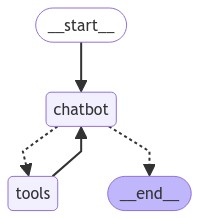

In [86]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [87]:
import re


def sanitize_name(name: str) -> str:
    """Sanitize the name to match the pattern '^[a-zA-Z0-9_-]+$'."""
    return re.sub(r"[^a-zA-Z0-9_-]", "_", name)

In [88]:
import asyncio

from langchain_core.messages import HumanMessage


async def chat_loop():
    config = {"configurable": {"thread_id": "0"}}

    while True:
        user_input = await asyncio.get_event_loop().run_in_executor(
            None, input, "User: "
        )
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        sanitized_name = (
            sanitize_name("Human") or "Anonymous"
        )  # Fallback if sanitized name is empty
        state = {"messages": [HumanMessage(content=user_input, name=sanitized_name)]}

        print("Assistant: ", end="", flush=True)

        max_retries = 3
        retry_delay = 1

        for attempt in range(max_retries):
            try:
                async for chunk in graph.astream(state, config, stream_mode="values"):
                    if chunk.get("messages"):
                        last_message = chunk["messages"][-1]
                        if isinstance(last_message, AIMessage):
                            last_message.name = (
                                sanitize_name(last_message.name or "AI") or "AI"
                            )
                            print(last_message.content, end="", flush=True)
                    elif isinstance(last_message, ToolMessage):
                        print(f"\n[Tool Used: {last_message.name}]")
                        print(f"Tool Call ID: {last_message.tool_call_id}")
                        print(f"Content: {last_message.content}")
                        print("Assistant: ", end="", flush=True)
                break
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"\nAn unexpected error occurred: {e!s}")
                    print(f"\nRetrying in {retry_delay} seconds...")
                    await asyncio.sleep(retry_delay)
                    retry_delay *= 2
                else:
                    print(f"\nMax retries reached. OpenAI API error: {e!s}")
                    break

        print("\n")  # New line after the complete response

In [ ]:
# For Jupyter notebooks and IPython environments
import nest_asyncio

nest_asyncio.apply()

# Run the async function
await chat_loop()